# Unsupervised denoising

* Dataset from [Hagen, et al. 2021](https://doi.org/10.1093/gigascience/giab032)
* Based on U-Net with identical input and target images
* Overfitting is avoided with the use of an experimental self-limiting loss model
    * The loss model internally contains two competing network
    * Basic implementation assumes pixel-independent Gaussian noise

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot
import os
from importlib import reload

import torch
from torch import nn
import torchvision
from torchinfo import summary
from torch.utils.data import DataLoader

from smlm_dl import config, dataset, fileloader, model, trainer, loss

In [2]:
# high_snr_fpath = os.path.join(config.config["TEST_DATASET_PATH"]["Hagen"], "01-actin-60x-noise1", "actin-60x-noise1-highsnr.tif")
low_snr_fpath = os.path.join(config.config["TEST_DATASET_PATH"]["Hagen"], "01-actin-60x-noise1", "actin-60x-noise1-lowsnr.tif")

filepath: /home/kkc29/project/datasets/Hagen/01-actin-60x-noise1/actin-60x-noise1-lowsnr.tif, frames: 100, image shape: (1, 2048, 2048)


/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/dataset.py:441: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


174:	 [id = 174.000,],
204:	 [id = 204.000,],
14:	 [id = 14.000,],
465:	 [id = 465.000,],
402:	 [id = 402.000,],
503:	 [id = 503.000,],
387:	 [id = 387.000,],
341:	 [id = 341.000,],
filepath: /home/kkc29/project/datasets/Hagen/01-actin-60x-noise1/actin-60x-noise1-lowsnr.tif, frames: 100, image shape: (1, 2048, 2048)
379:	 [id = 379.000,],
99:	 [id = 99.000,],
112:	 [id = 112.000,],
160:	 [id = 160.000,],
167:	 [id = 167.000,],
450:	 [id = 450.000,],
392:	 [id = 392.000,],
447:	 [id = 447.000,],


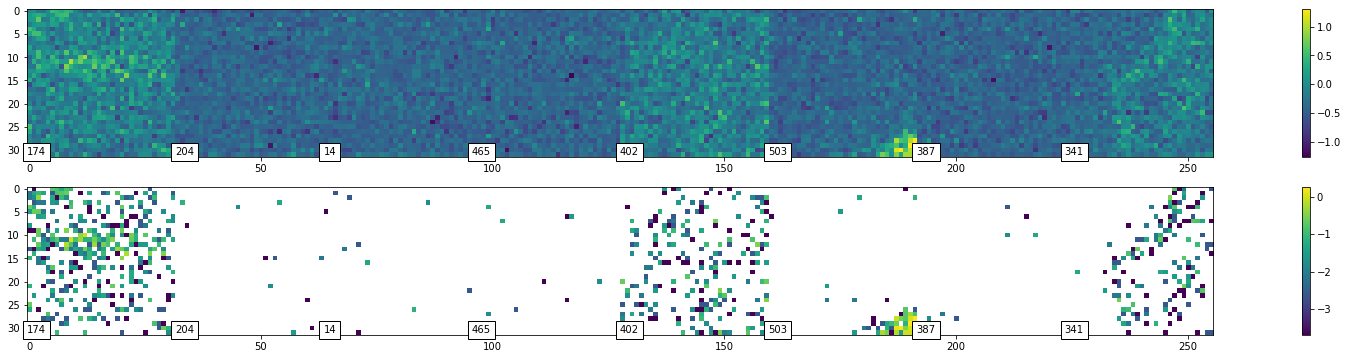

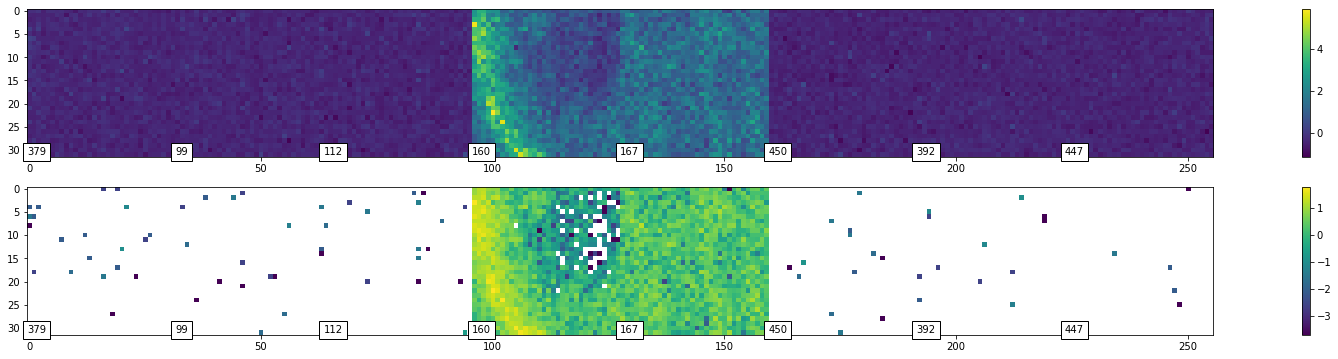

In [3]:
image_out_size = (32, 32)
training_image_slice = slice(0, -10)
validation_image_slice = slice(-10, None)

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomCrop(image_out_size),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
)

training_data = dataset.FileDataset(low_snr_fpath,
                                    image_slice=training_image_slice,
                                    transform=transforms,
                                    length=512,
                                    file_loader=fileloader.PilImageFileLoader,
                                    slices=(slice(None),slice(None)), stack_to_volume=False, cache=True)
training_data.file.images = torch.as_tensor(training_data.file.images, device="cuda")
training_data_mean = training_data.file.images[training_image_slice].mean()
training_data_std = training_data.file.images[training_image_slice].std()
torchvision.transforms.functional.normalize(training_data.file.images, training_data_mean, training_data_std, True)
dataset.inspect_images(training_data)

validation_data = dataset.FileDataset(low_snr_fpath,
                                      image_slice=validation_image_slice,
                                      transform=transforms,
                                      length=512,
                                      file_loader=fileloader.PilImageFileLoader,
                                      slices=(slice(None),slice(None)), stack_to_volume=False, cache=True)
validation_data.file.images = torch.as_tensor(validation_data.file.images, device="cuda")
torchvision.transforms.functional.normalize(validation_data.file.images, training_data_mean, training_data_std, True)
dataset.inspect_images(validation_data)

In [4]:
train_dataloader = DataLoader(training_data, batch_size=512, shuffle=True)
valid_dataloader = DataLoader(validation_data, batch_size=512, shuffle=True)

max_psf_count, params_ref_no_scale ignored
Layer (type (var_name))                       Output Shape              Param #
BaseFitModel                                  --                        --
├─DirectImageMapperModel (mapper)             --                        --
│    └─ModuleDict (mapping_modules)           --                        --
├─PassthroughRenderer (renderer)              --                        --
├─UnetEncoderModel (encoder)                  [32, 1, 32, 32]           --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 32, 32]          --
│    │    │    └─Identity (0)                 [32, 1, 32, 32]           --
│    │    │    └─Conv2d (1)                   [32, 16, 32, 32]          160
│    │    │    └─GELU (2)                     [32, 16, 32, 32]          --
│    │    │    └─Identity (3)                 [32, 16, 32, 32]          --
│    │    │    └─Conv2d (4)                   [32, 

/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/model/base.py:151: RuntimeWarning: invalid value encountered in log10
  im = axes[0, i].imshow(np.log10(img))


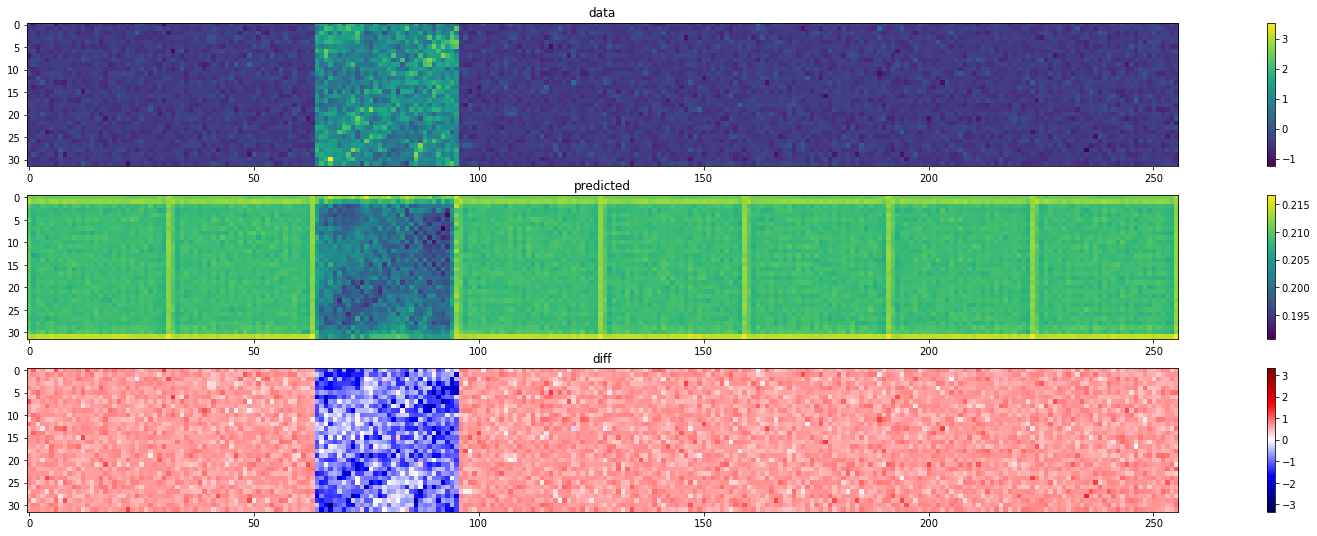

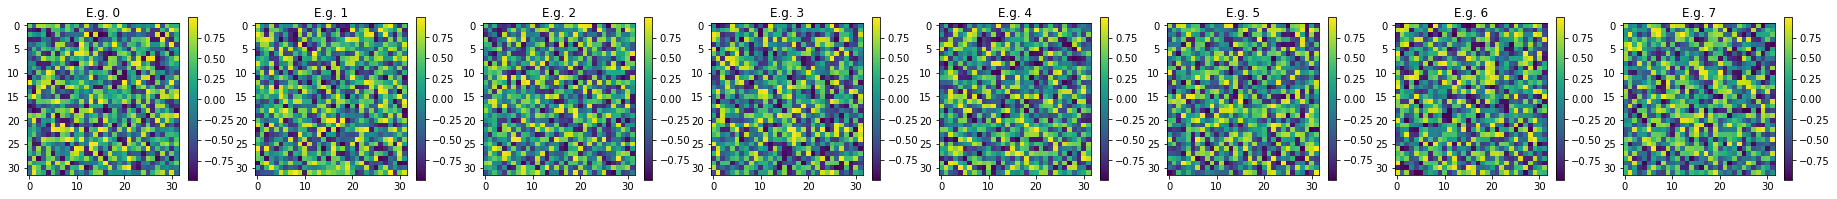

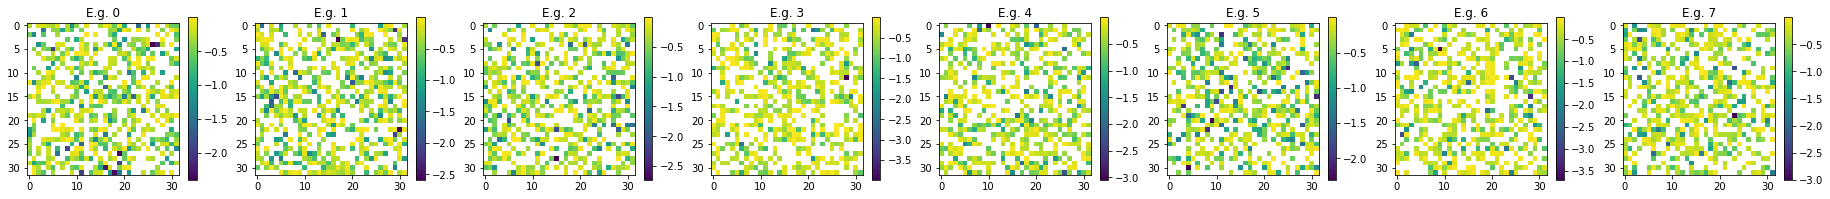

In [5]:
fitting_model = model.BaseFitModel(encoder_class=model.UnetEncoderModel,
                                   renderer_class=model.renderer.PassthroughRenderer,
                                   mapper_class=model.mapper.DirectImageMapperModel,
                                   img_size=image_out_size,
                                   fit_params=['ch0', ],
                                   params_ref_override = {'ch0': model.FitParameter(nn.Identity(), 0, 1, 0, False)},
                                   encoder_params = {
                                       "depth":4,
                                       "first_layer_out_channels":16,
                                       "dropout_conv": 0.25,
                                       "dropout_neck": 0,
                                       "act_func":nn.GELU,
                                       "final_act_func":nn.Identity
                                   },
                                  )

print(summary(fitting_model, input_size=(32,1)+image_out_size, row_settings=["var_names"], depth=4))
model.check_model(fitting_model, train_dataloader)

Device: cuda
Saved model to : /home/kkc29/scratch60/runs/2022-05-01_05-05-43_c18n07.farnam.hpc.yale.internal_Denoising_SelfLimitingLoss/model.ptm
Saved loss model : /home/kkc29/scratch60/runs/2022-05-01_05-05-43_c18n07.farnam.hpc.yale.internal_Denoising_SelfLimitingLoss/loss.ptm


  0%|          | 0/8000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 999. Saved to : /home/kkc29/scratch60/runs/2022-05-01_05-05-43_c18n07.farnam.hpc.yale.internal_Denoising_SelfLimitingLoss/checkpoint.ptc
Epoch 1999. Saved to : /home/kkc29/scratch60/runs/2022-05-01_05-05-43_c18n07.farnam.hpc.yale.internal_Denoising_SelfLimitingLoss/checkpoint.ptc
Epoch 2999. Saved to : /home/kkc29/scratch60/runs/2022-05-01_05-05-43_c18n07.farnam.hpc.yale.internal_Denoising_SelfLimitingLoss/checkpoint.ptc
Epoch 3999. Saved to : /home/kkc29/scratch60/runs/2022-05-01_05-05-43_c18n07.farnam.hpc.yale.internal_Denoising_SelfLimitingLoss/checkpoint.ptc
Epoch 4999. Saved to : /home/kkc29/scratch60/runs/2022-05-01_05-05-43_c18n07.farnam.hpc.yale.internal_Denoising_SelfLimitingLoss/checkpoint.ptc
Epoch 5999. Saved to : /home/kkc29/scratch60/runs/2022-05-01_05-05-43_c18n07.farnam.hpc.yale.internal_Denoising_SelfLimitingLoss/checkpoint.ptc
Epoch 6999. Saved to : /home/kkc29/scratch60/runs/2022-05-01_05-05-43_c18n07.farnam.hpc.yale.internal_Denoising_SelfLimitingLoss/checkpoi

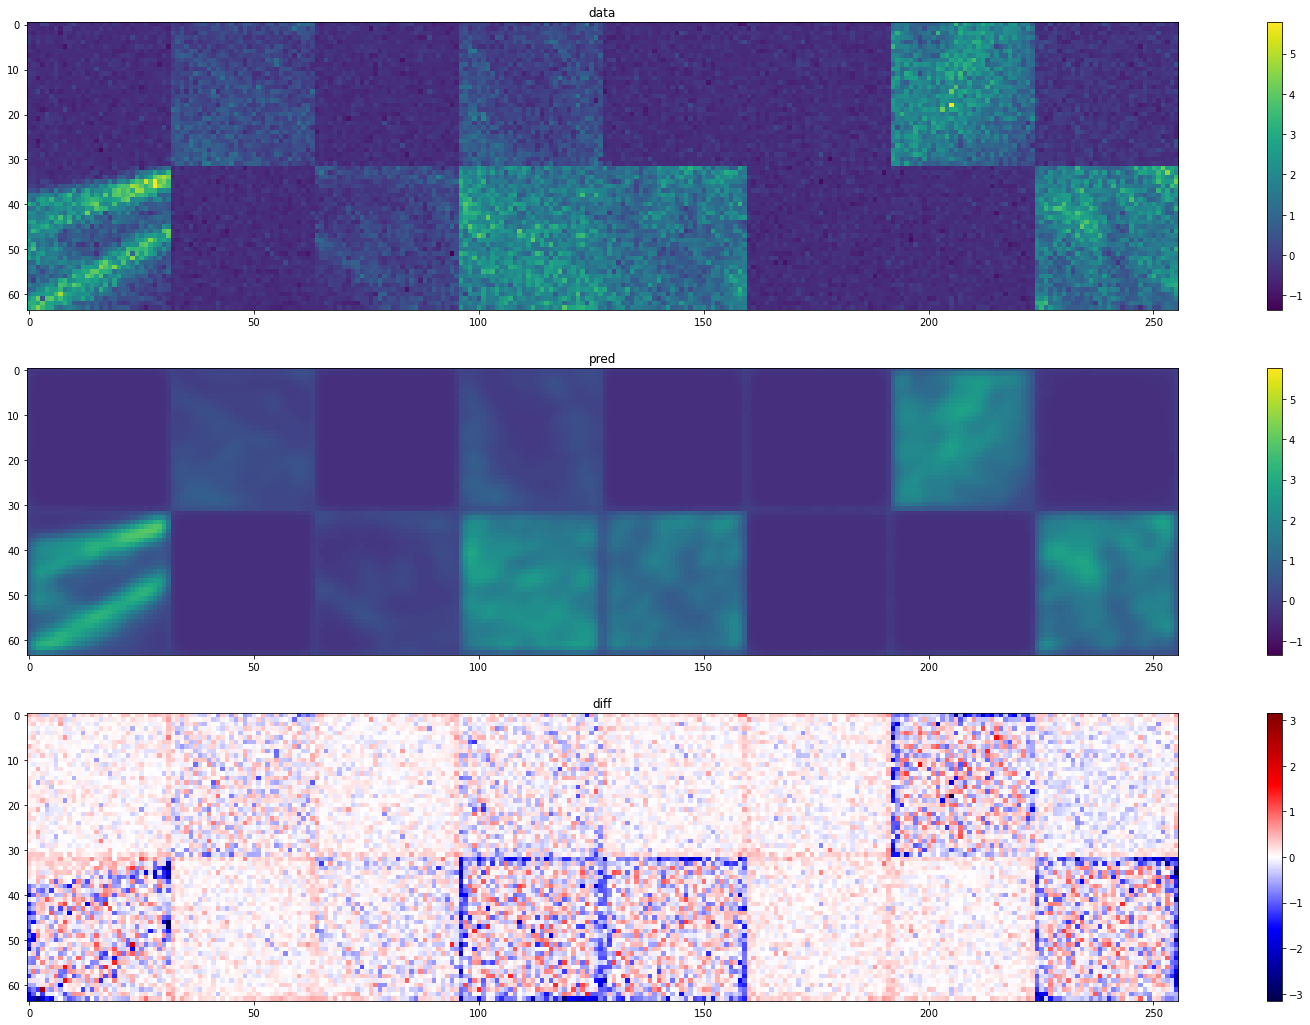

In [6]:
loss_func = loss.SelfLimitingLoss(crop=4, n_inner_iter=(300,1))
optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=5e-5)
training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer=optimizer, loss_function=loss_func)

dict_log = {}
training.train_and_validate(8000, 20, 200, tb_logger=True, label="Denoising_SelfLimitingLoss", dict_log=dict_log)

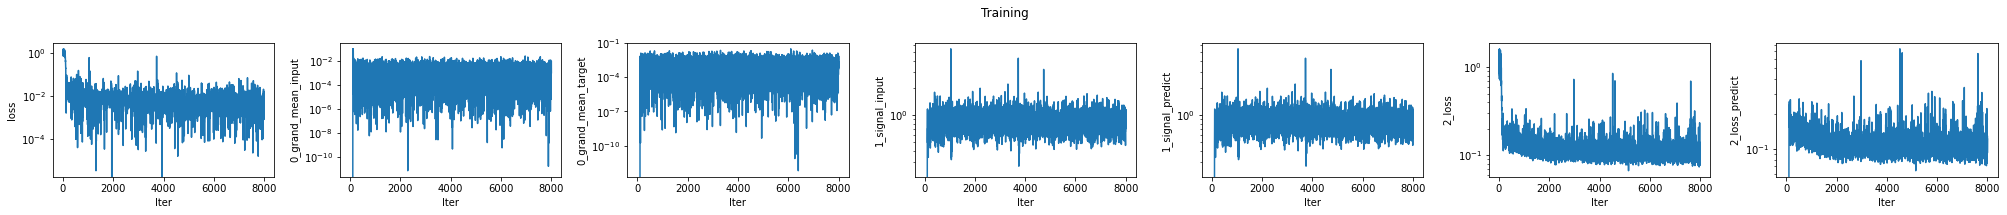

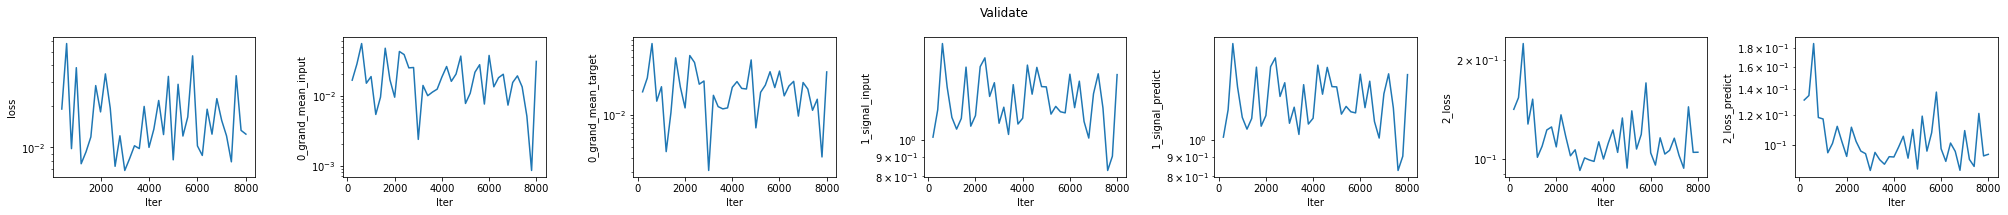

In [7]:
trainer.inspect_dict_log(dict_log, log=True);